In [16]:
from scipy.stats import *
import math
import pandas
import simpy
import seaborn
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import numpy as np
np.random.seed(421)

def strokeSim(xCSC = .5, yCSC =.5, xPSC = .2, yPSC = .5, sensitivity = .8, specificity = .8, \
              scale = 18.64, threshold = 20, patients = 1000, driveTimeFactor = 60/35, runID = "A1", save = False, plot = True, 
             two_psc = False, savePlot = False):
    output_data = []
    xCSC *= scale
    yCSC *= scale
    xPSC *= scale
    yPSC *= scale
    xPSC2 = 15
    yPSC2 = 5
    
    
    def runSim():
        env = simpy.Environment()
        strokePatient1 = strokePatient(env)
        for i in range(0,patients):
            strokePatients = strokePatient(env)
        env.run()

        #collect and plot data

        myData = pandas.DataFrame(output_data)
        myData["destination"].astype('category')
        myData["Correct_destination"].astype('category')
        myData["result"].astype('category')
        myData["confusion"].astype('category')
        print((myData["LVO_diagnosis"] == myData["hasLVO"]).mean())
        #print(myData.query('hasLVO == True'))
        return myData
        #print(myData["destination"].describe())
    
    def plotOutput(myData):
        colors = ["blue", "orange", "#66ff00"]
        seaborn.set_palette(seaborn.color_palette(colors))
        
        #PLOT 1
        fig, ax = plt.subplots()
       
        
        ax = seaborn.scatterplot(x = 'xLocation', y = 'yLocation', data = myData, hue = 'destination')
        aug1 = plt.plot(xCSC,yCSC, 'or', marker = "^", markersize = "14", label = "CSC")
        aug2 = plt.plot(xPSC,yPSC, 'or', marker = "s", markersize = "10", label = "PSC",color = 'purple')
        if two_psc:
            aug3 = plt.plot(xPSC2, yPSC2, 'or', marker = "v", markersize = '14', label = "PSC-2", color = 'yellow')
        ax.legend(bbox_to_anchor = (1,1), loc = 0)
        print("CSC located at %s, %s" % (xCSC, yCSC))
        print("PSC located at %s, %s" % (xPSC, yPSC))
        plt.title("n = %s" % patients)
        plt.xlabel("Distance (Miles)")
        plt.ylabel("")
        if savePlot:
            plt.savefig(fname = 'destination_map.jpg', bbox_inches = "tight")
        #PLOT 2
        fig,ax = plt.subplots()
        ax = seaborn.scatterplot(x = 'xLocation', y = 'yLocation', 
                                 data = myData.query('confusion != "TN"'), hue = 'result')
        
        x_loc = [xCSC, xPSC]
        y_loc = [yCSC, yPSC]
        aug1 = plt.plot(xCSC,yCSC, 'or', marker = "^", markersize = "14", label = "CSC")
        aug2 = plt.plot(xPSC,yPSC, 'or', marker = "s", markersize = "10", label = "PSC",color = 'purple')
        if two_psc:
            aug3 = plt.plot(xPSC2, yPSC2, 'or', marker = "v", markersize = '14', label = "PSC-2", color = 'yellow')
        ax.legend(bbox_to_anchor = (1,1), loc = 0)
        plt.title("n = %s" % patients)
        plt.xlabel("Distance (Miles)")
        plt.ylabel("")
        if savePlot:
            plt.savefig(fname = 'result_map.jpg', bbox_inches = 'tight')
        plt.show()
    
    def saveData(myData, runID):
        myData.to_csv('%s.csv' % runID, mode = 'w', header = True, index = False)
            
            
    class strokePatient(object):
        def __init__(self, env):
            #object attributes
            self.destination = ""
            self.correct_destination = ""
            self.timeInSystem = 0
            #scale_distance = 40
            self.xLocation = uniform.rvs(0,1) * scale
            self.yLocation = uniform.rvs(0,1) * scale
            self.distFromCSC = math.hypot(xCSC - self.xLocation, yCSC - self.yLocation) # * scale_distance
            self.distFromPSC = math.hypot(xPSC - self.xLocation, yPSC - self.yLocation) # * scale_distance
            self.distFromPSC2 = math.hypot(xPSC2 - self.xLocation, yPSC2 - self.yLocation)
################################################ time to hospital ###########################
            
            self.time2PSC = driveTimeFactor * self.distFromPSC + norm.rvs(0,driveTimeFactor * self.distFromPSC * .1)
            self.time2CSC = driveTimeFactor * self.distFromCSC + norm.rvs(0,driveTimeFactor * self.distFromCSC * .1)
            self.time2PSC2 = driveTimeFactor * self.distFromPSC2 + norm.rvs(0,driveTimeFactor * self.distFromPSC2 * .1)
            
###############################################################################################33            
            self.timeAtScene = 0
            self.time2Scene = 0
            self.time2Hospital = 0
            
            self.LVO_diagnosis = False
            self.result = "correct"
            self.closest_hospital = "PSC"
            self.confusion = "TN"
            if self.distFromCSC < self.distFromPSC:
                self.closest_hospital = "CSC"
            if two_psc:
                if self.distFromPSC2 < self.distFromPSC and self.distFromPSC2 < self.distFromCSC:
                    self.closest_hospital = "PSC2"
                
                
            self.times = {"PSC" : self.time2PSC, "CSC" : self.time2CSC, "PSC2" : self.time2PSC2}
            
######################### Hemorrhaging or Ischemic ############################            
            self.hasStroke = bool(bernoulli.rvs(p = .4))
            if self.hasStroke:
                if bool(bernoulli.rvs(p=.13)):
                    self.hemorrhaging = True
                    self.ischemic = False
                else:
                    self.ischemic = True
                    self.hemorrhaging = False
                
            else: 
                self.hemorrhaging = False
                self.ischemic = False
################################# LVO #########################################
            if self.ischemic:
                if bool(bernoulli.rvs(p = .387)):
                    self.hasLVO = True
                    self.correct_destination = "CSC"
                else:
                    self.hasLVO = False
                    self.correct_destination = self.closest_hospital
            else:
                self.hasLVO = False
                self.correct_destination = self.closest_hospital
#             if (self.hasStroke):
#                 self.hasLVO = bool(bernoulli.rvs(p = .2))
#                 self.correct_destination = "CSC"
#             else: 
#                 self.hasLVO = False
#                 self.correct_destination = "PSC"
            
            lastWell = uniform.rvs(0,1)
            if lastWell <= 1:
                self.last_well = uniform.rvs(3,6)
            if lastWell <= .77:
                self.last_well = uniform.rvs(6,24)
            if lastWell <= .46:
                self.last_well = uniform.rvs(0,3)
            
            self.env = env
            # Start the run process everytime an instance is created.
            self.action = env.process(self.run())


        def toString(self):
            return {"hasStroke" : self.hasStroke, "hasLVO" : self.hasLVO, "LVO_diagnosis" : self.LVO_diagnosis, \
                    "last_well": self.last_well, "destination" : self.destination, \
                    "Correct_destination": self.correct_destination, "result": self.result, \
                    "confusion": self.confusion, 'time2Scene': self.time2Scene, 'timeAtScene': self.timeAtScene, \
                    "timeInSystem" : self.timeInSystem, "time2Hospital" : self.time2Hospital, \
                    "closest_hospital": self.closest_hospital, "xLocation" : self.xLocation, "yLocation" : self.yLocation,
                   "time2PSC": self.time2PSC, "time2CSC": self.time2CSC, 'time2PSC2': self.time2PSC2, 'hemorrhaging': self.hemorrhaging,
                   "ischemic": self.ischemic}

        def charge(self, duration):
            yield self.env.timeout(duration)

        def ems2scene(self):
            wait = norm.rvs(15.1, 7)
            
            self.time2Scene += 1.62
            self.time2Scene += wait
            if self.time2Scene < 1:
                self.time2Scene = 1
                self.timeInSystem += 1
                
            else:    
                self.timeInSystem += 1.62
                self.timeInSystem += wait
            #print("Waiting for EMS to arrive (1.62 mins)")
            yield self.env.timeout(self.time2Scene)

        def emsAtScene(self):
            wait = beta.rvs(2.91, 6.056, scale = 40)
            self.timeInSystem += wait
            self.timeAtScene += wait
            #print("EMS on scene for (%s minutes)" % wait)
            yield self.env.timeout(wait)

        def ems2Hospital(self):
            wait = 0
            
            time2PSC = driveTimeFactor * self.distFromPSC
            time2CSC = driveTimeFactor * self.distFromCSC
            time2PSC2 = driveTimeFactor * self.distFromPSC2
############################## True positive and negative ########################3333            
            self.LVO_diagnosis = self.diagnosePatient()
            if self.LVO_diagnosis and self.hasLVO:
                self.confusion = "TP"
            elif self.LVO_diagnosis and not self.hasLVO:
                self.confusion = "FP"
            elif not self.LVO_diagnosis and self.hasLVO:
                self.confusion = "FN"
############################## DESTINATION LOGIC ##########################################
            if not two_psc:
                if self.LVO_diagnosis and self.last_well <= 6:
                    if time2CSC - time2PSC < threshold:
                        self.destination = "CSC"
                        wait = self.time2CSC
                    else:
                        self.destination = "PSC"
                        wait = self.time2PSC
                elif time2CSC < time2PSC:
                    self.destination = "CSC"
                    wait = self.time2CSC
                else:
                    self.destination = "PSC"
                    wait = self.time2PSC
            else:
                
                if self.LVO_diagnosis and self.last_well <= 6:
                    if time2CSC - time2PSC < threshold:
                        self.destination = "CSC"
                        wait = time2CSC
                    else:
                        self.destination = self.closest_hospital
                        wait = self.times[self.closest_hospital]
                else:
                    self.destination = self.closest_hospital
                    wait = self.times[self.closest_hospital]
                
            
            if self.hasLVO and self.destination != "CSC" and self.last_well <= 6:
                self.result = "undertriage"
            if self.destination == "CSC" and self.hasLVO == False and self.closest_hospital != "CSC":
                self.result = "overtriage"
            self.time2Hospital += wait
            self.timeInSystem += wait
            yield self.env.timeout(wait)

        def run(self):
            yield self.env.process(self.ems2scene())
            yield self.env.process(self.emsAtScene())
            yield self.env.process(self.ems2Hospital())
            data = self.toString()
            output_data.append(data)

            #print("total time in system: %d minutes" % self.timeInSystem)
            #print(self.distFromCSC, self.distFromPSC)
        
        def diagnosePatient(self):
            if self.hasLVO:
                return bool(bernoulli.rvs(p = sensitivity))
            else:
                return not (bool(bernoulli.rvs(p = specificity)))
                
    # running the sim    
    data = runSim()
    if plot:
        plotOutput(data)
    if save:
        saveData(data, runID)

    average = data["timeInSystem"].mean()
    return average

    
#strokeSim(plot = True, patients = 3000, save = True, runID = "test_2psc2", two_psc = True, savePlot = True)    
    

In [205]:
averages = []

for i in range(0,25):
    averages.append(strokeSim(plot = False))
    
print(averages)



0.8032196780321967
0.7973202679732027
0.7958204179582041
0.801919808019198
0.8023197680231977
0.7968203179682032
0.7971202879712029
0.8062193780621938
0.7952204779522047
0.8013198680131987
0.7971202879712029
0.7984201579842016
0.7936206379362064
0.8016198380161984
0.7992200779922007
0.7972202779722027
0.7977202279772023
0.7978202179782021
0.8054194580541946
0.8022197780221978
0.7983201679832017
0.8023197680231977
0.7967203279672033
0.799020097990201
0.8041195880411959
[9.951341496508679, 10.08773763523473, 10.087984065223967, 10.045333006768244, 9.941302997647156, 10.040764203372678, 10.049175861860157, 9.96574265405914, 10.067360649021197, 9.998917641939492, 10.022648037007372, 10.116731081716845, 10.044106635913849, 9.912042965879033, 9.974801893279942, 9.986671006699222, 10.079375592366898, 10.006090559785743, 10.012341746225776, 9.99729400283143, 10.019847353267014, 10.010458965638312, 10.028012961807162, 10.006898004804174, 10.05850278656006]


Text(0.5,1,'25 replications of n = 10000 patients')

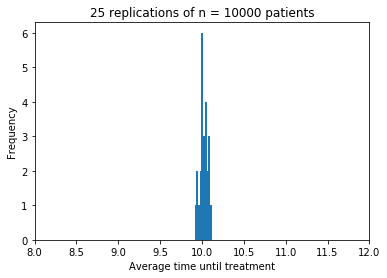

In [211]:
plt.hist(averages)
plt.xlim(8,12)
plt.xlabel("Average time until treatment")
plt.ylabel("Frequency")
plt.title("25 replications of n = 10000 patients")

In [207]:
averages1 = []

for i in range(0,50):
    averages1.append(strokeSim(plot = False,patients = 5000))
    
print(averages1)

0.8070385922815437
0.8124375124975005
0.7956408718256349
0.8076384723055389
0.7990401919616077
0.8008398320335933
0.7976404719056189
0.7972405518896221
0.8004399120175965
0.7944411117776444
0.7866426714657069
0.7944411117776444
0.7798440311937612
0.8118376324735053
0.7998400319936013
0.7944411117776444
0.8088382323535293
0.8070385922815437
0.7924415116976604
0.8076384723055389
0.7968406318736253
0.7988402319536093
0.8080383923215357
0.7994401119776045
0.7936412717456509
0.7964407118576284
0.8024395120975805
0.8090381923615277
0.7962407518496301
0.7938412317536493
0.7838432313537292
0.8022395520895821
0.8032393521295741
0.8020395920815837
0.8026394721055788
0.7962407518496301
0.7906418716256749
0.8026394721055788
0.8070385922815437
0.8024395120975805
0.7920415916816637
0.8112377524495101
0.8030393921215757
0.8034393121375725
0.8014397120575885
0.8096380723855229
0.8034393121375725
0.8034393121375725
0.7956408718256349
0.8036392721455708
[10.09767710006378, 9.92250755240782, 10.091436428

Text(0.5,1,'50 replications of n = 5000 patients')

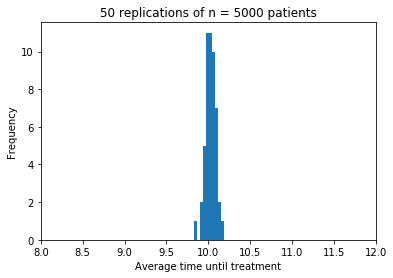

In [210]:
plt.hist(averages1)
plt.xlim(8,12)
plt.xlabel("Average time until treatment")
plt.ylabel("Frequency")
plt.title("50 replications of n = 5000 patients")

In [212]:
averages2 = []

for i in range(0,50):
    averages2.append(strokeSim(plot = False, patients = 10000))
    
print(averages2)

0.7951204879512048
0.802019798020198
0.8037196280371963
0.7977202279772023
0.8031196880311969
0.8026197380261973
0.8054194580541946
0.7998200179982001
0.8004199580041996
0.8015198480151985
0.8009199080091991
0.8003199680031997
0.7987201279872013
0.801019898010199
0.7996200379962004
0.7996200379962004
0.802019798020198
0.7989201079892011
0.8054194580541946
0.7994200579942006
0.7975202479752025
0.8048195180481952
0.8054194580541946
0.7921207879212079
0.7951204879512048
0.7922207779222078
0.8007199280071993
0.8035196480351965
0.7986201379862014
0.7926207379262074
0.7988201179882012
0.7991200879912009
0.7995200479952005
0.7946205379462054
0.7958204179582041
0.8088191180881912
0.803019698030197
0.7992200779922007
0.8028197180281972
0.7988201179882012
0.7966203379662034
0.8033196680331967
0.7999200079992
0.7938206179382061
0.7998200179982001
0.8023197680231977
0.7988201179882012
0.8036196380361964
0.8032196780321967
0.8108189181081892
[10.037208621949134, 10.058115924149782, 10.0410567034974

Text(0.5,1,'50 replications of n = 10000 patients')

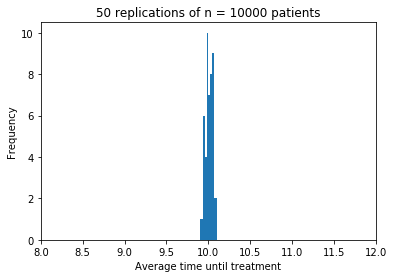

In [213]:
plt.hist(averages2)
plt.xlim(8,12)
plt.xlabel("Average time until treatment")
plt.ylabel("Frequency")
plt.title("50 replications of n = 10000 patients")

In [214]:
averages3 = []

for i in range(0,25):
    averages3.append(strokeSim(plot = False, patients = 5000))
    
print(averages3)

0.7954409118176364
0.7934413117376524
0.8018396320735853
0.8082383523295341
0.7992401519696061
0.7962407518496301
0.7984403119376124
0.8090381923615277
0.8046390721855629
0.8000399920015997
0.8038392321535693
0.7946410717856429
0.7910417916416717
0.7934413117376524
0.7982403519296141
0.8024395120975805
0.7992401519696061
0.7988402319536093
0.8158368326334733
0.7980403919216157
0.8000399920015997
0.7934413117376524
0.8022395520895821
0.7992401519696061
0.8058388322335532
[10.044111984531622, 10.104005243649848, 9.998774944434022, 10.105091771269432, 9.991933008577458, 10.090199346964033, 10.028077243274288, 9.933289951677436, 10.14232136453624, 10.015839192470072, 10.130262905479292, 10.110196971332234, 10.054425499745742, 10.168925818314126, 10.199180617653724, 10.168532570447027, 9.859315252581824, 9.964489732119262, 9.99523815309579, 10.054676444933419, 10.06589198260382, 9.996752762254406, 9.950440087522148, 9.931606211709223, 10.033094082974564]


Text(0.5,1,'25 replications of n = 5000 patients')

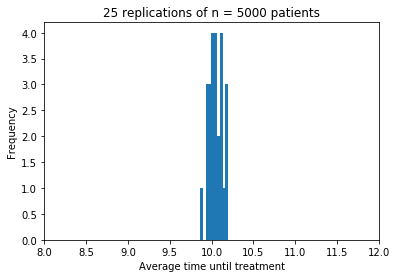

In [215]:
plt.hist(averages3)
plt.xlim(8,12)
plt.xlabel("Average time until treatment")
plt.ylabel("Frequency")
plt.title("25 replications of n = 5000 patients")

0.7887370876374542
CSC located at 9.32, 9.32
PSC located at 3.728, 9.32


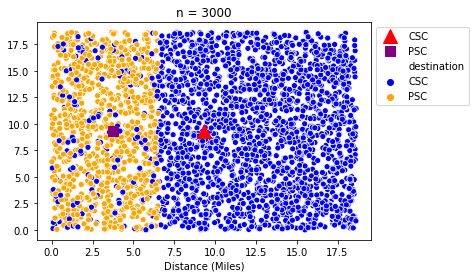

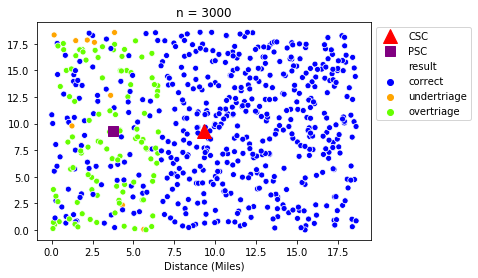

10.017541603932253

In [271]:
strokeSim(patients = 3000)

15.874584870233113
15.869040372792522


(array([0.01342468, 0.00915632, 0.01425082, 0.01672922, 0.02457749,
        0.03098003, 0.03476648, 0.04447356, 0.05232184, 0.05218415,
        0.05590175, 0.05376757, 0.0539741 , 0.05080726, 0.04254591,
        0.03807102, 0.02898354, 0.02361367, 0.01569655, 0.01163472,
        0.00860557, 0.00468143, 0.00282263, 0.00165227, 0.00144573,
        0.00089498, 0.00034422, 0.        , 0.        , 0.00013769]),
 array([ 0.        ,  1.45254843,  2.90509686,  4.35764528,  5.81019371,
         7.26274214,  8.71529057, 10.167839  , 11.62038743, 13.07293585,
        14.52548428, 15.97803271, 17.43058114, 18.88312957, 20.33567799,
        21.78822642, 23.24077485, 24.69332328, 26.14587171, 27.59842014,
        29.05096856, 30.50351699, 31.95606542, 33.40861385, 34.86116228,
        36.3137107 , 37.76625913, 39.21880756, 40.67135599, 42.12390442,
        43.57645284]),
 <a list of 30 Patch objects>)

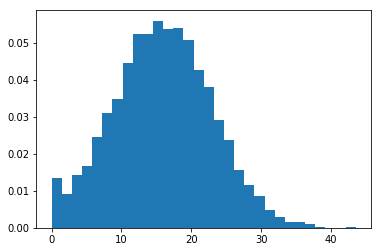

In [68]:
import numpy as np
np.random.seed(421)
from scipy import stats
from matplotlib import pyplot as plt




newt2s = stats.skewnorm.rvs(loc = 16.1, scale = 7.0, size = 10000, a = -.05)
newt2s[newt2s < 0] = 0

print(np.mean(newt2s))
print(np.median(newt2s))



plt.hist(newt2s, density =True, bins = 30)

0.8043985338220593
CSC located at 9.32, 9.32
PSC located at 3.728, 9.32


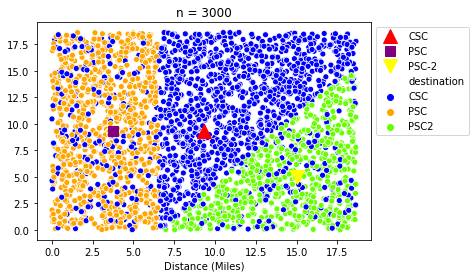

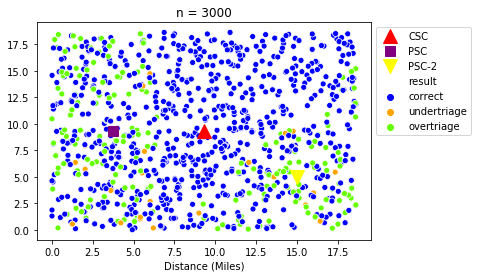

35.0020732454423

In [17]:
strokeSim(plot = True, patients = 3000, save = True, runID = "2psc_1", two_psc = True, savePlot = True)

In [77]:
from scipy import stats
miles = 8
factor = 60/35
time = miles * factor
stats.norm.rvs(0, time*.1)


-1.0996540115059859